Reilly Bergeron

Asa Ben-Hur

CS 345 Machine Learning Foundations and Practice

12/7/23


# Artist Identification Using a Convolutional Neural Network

The purpose of this project is to learn how to use a CNN (Convolutional Neural Network) to identify different characterstics contained within an image, based on a large amount of images. I'm doing this by attempting to identify various artists based on images of their paintings. The dataset used for this is a Kaggle dataset named "Best Artworks of All Time: Collection of Paintings of the 50 Most Influential Artists of All Time". The dataset characteristics will be further discussed at a later point. Concerning the model that will be used, ResNet50 is a compelling choice for identifying artists based on their paintings due to its deep convolutional neural network architecture, specifically designed for image classification tasks. Trained on a vast dataset like ImageNet, ResNet50 has learned a rich hierarchy of features, capturing intricate patterns and details in images. This pre-trained model excels in discerning subtle visual nuances, which is crucial when distinguishing an artist's unique style, brushstrokes, and color palettes. The depth of ResNet50 allows it to grasp both global and fine-grained features in artworks, providing a comprehensive representation that aids in accurate artist identification. By freezing early layers and fine-tuning the model on a dataset of paintings, ResNet50 leverages its learned features to effectively transfer knowledge, making it an efficient and powerful tool for the nuanced task of attributing artworks to specific artists.

IMPORTANT NOTE: To be able to run this Jupyter Notebook, a kaggle.json file is required to be imported into the runtime. This is used to retrieve the dataset from Kaggle. I have turned in my kaggle.json in addition to this file, in case the notebook needs to be ran for grading purposes.

# Necessary imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import datasets, layers, models
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.layers import Dense, Flatten, BatchNormalization, Activation
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.preprocessing import image
from keras.preprocessing import *
from google.colab import files
from sklearn.metrics import *

# Reading the Data

Reading the data was a unique challenge, as it totals to 2 GB. Uploading the files to Google Colab was immediately deemed infeasible, as the upload speed is far too slow, and they would have to be reuploaded every time the runtime would time out. My next option was uploading the data to my Google Drive, mounting my drive from within Google Colab, and then accessing the files through there. I ran into issues with this as well, as accessing the files (specifically the images of paintings) from drive added a lot of overhead, meaning training the CNN would take over an hour for each epoch. Minimizing this overhead is crucial for optimizing the efficiency and speed of your workflow. This lead me to loading the files into Google Colab straight from Kaggle.

In [ ]:
%%capture
#This line captures the output of this entire cell, as unzipping the file returned the name of every file contained within best-artworks-of-all-time.zip
#This will take around 2 minutes
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download ikarus777/best-artworks-of-all-time
! unzip best-artworks-of-all-time.zip

In [ ]:
artists = pd.read_csv('/content/artists.csv')
artists.head()

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194


Artists.csv is the dataset of information for each artist, and it's structure is shown above. It contains 50 rows, with each row having the features id, name, years, genre, nationality, bio, wikipedia, and paintings. For the purpose of this project, the only ones we care about are the name of the artist, and the number of paintings contained within the dataset for each artist. Also contained within the dataset is a folder named images and a folder named resized. Images is a collection of images (full size), divided in folders and sequentially numbered. Resized is the images resized and extracted from folder structure. We will be using the full size images for training, however we later resize them to work with Resnet50.

# Processing the Data

I've only used artists with greater than or equal to 100 images contained within the dataset. 20 of the artists within this dataset do not fall into that category, and they would have a considerable negative impact on the performance of the CNN due to having insignificant data to train the model. Since many of the artists have a different number of paintings, I've opted to weight the classes differently. Here, class_weight is calculated based on the number of paintings for each artist. The purpose of this is to give more importance to artists with fewer paintings. The idea is that the algorithm should not just focus on minimizing the error for artists with a large number of paintings but should also give due consideration to artists with fewer paintings. Class weights are important when dealing with imbalanced datasets as the algorithm may be biased towards the majority class and may perform poorly on the minority class. This is because the algorithm aims to minimize the overall error, and in an imbalanced dataset, it may prioritize the majority class. I have graphed the number of paintings for each artists, as well as their associated class weights. This section ends with me retrieving all of the image files for each artist.

In [ ]:
artists = artists.sort_values(by=['paintings'], ascending=False)
df = artists[artists['paintings'] >= 100].reset_index()
df = df[['name', 'paintings']]
df['class_weight'] = df.paintings.sum() / (df.paintings * df.shape[0])
class_weights = df['class_weight'].to_dict()

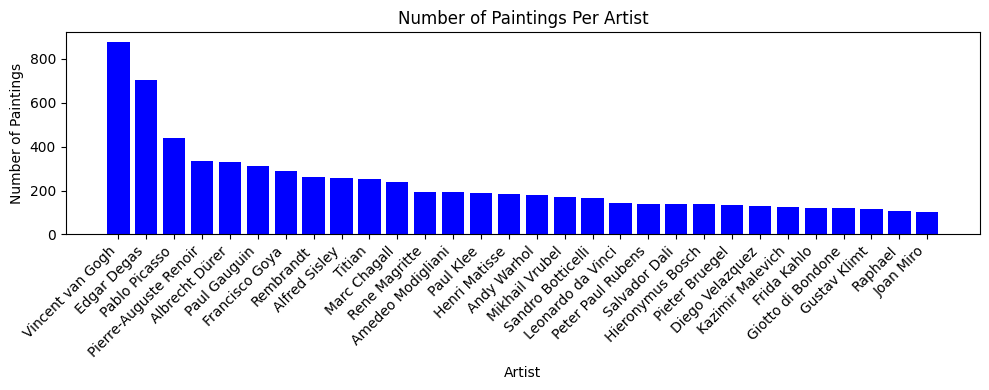

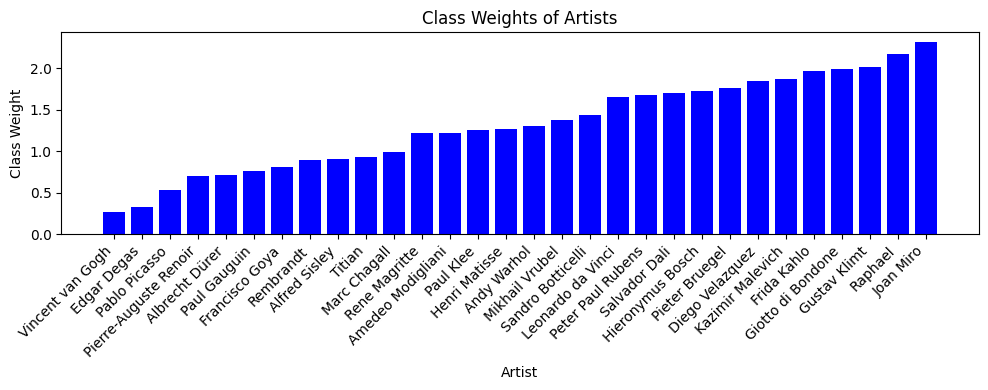

In [ ]:
plt.figure(figsize=(10, 4))
plt.bar(df['name'], df['paintings'], color='blue')
plt.xlabel('Artist')
plt.ylabel('Number of Paintings')
plt.title('Number of Paintings Per Artist')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
plt.figure(figsize=(10, 4))
plt.bar(df['name'], df['class_weight'], color='blue')
plt.xlabel('Artist')
plt.ylabel('Class Weight')
plt.title('Class Weights of Artists')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# The Albrecht Dürer files have some issues, making processing them very difficult. I've deemed it best to just remove them.
durer = "Albrecht Dürer"
df = df[df['name'] != durer].reset_index(drop=True)

In [ ]:
images_directory = '/content/images/images'
df_names = df['name'].str.replace(' ', '_').values
for name in df_names:
    if os.path.exists(os.path.join(images_directory, name)):
        print(os.path.join(images_directory, name))
    else:
        print("ERROR: ", os.path.join(images_directory, name))

/content/images/images/Vincent_van_Gogh
/content/images/images/Edgar_Degas
/content/images/images/Pablo_Picasso
/content/images/images/Pierre-Auguste_Renoir
/content/images/images/Paul_Gauguin
/content/images/images/Francisco_Goya
/content/images/images/Rembrandt
/content/images/images/Alfred_Sisley
/content/images/images/Titian
/content/images/images/Marc_Chagall
/content/images/images/Rene_Magritte
/content/images/images/Amedeo_Modigliani
/content/images/images/Paul_Klee
/content/images/images/Henri_Matisse
/content/images/images/Andy_Warhol
/content/images/images/Mikhail_Vrubel
/content/images/images/Sandro_Botticelli
/content/images/images/Leonardo_da_Vinci
/content/images/images/Peter_Paul_Rubens
/content/images/images/Salvador_Dali
/content/images/images/Hieronymus_Bosch
/content/images/images/Pieter_Bruegel
/content/images/images/Diego_Velazquez
/content/images/images/Kazimir_Malevich
/content/images/images/Frida_Kahlo
/content/images/images/Giotto_di_Bondone
/content/images/ima

# Augmenting the Data for Increased Performance

The chosen data augmentation techniques include horizontal and vertical flips, as well as shear transformations and rescaling of pixel values. These augmentations aim to increase the diversity of the training data, helping the model generalize better to various orientations and positions of artistic elements in the images. The training set is split into training and validation subsets, with 80% used for training and 20% for validation. The generator is set to work with batches of 16 images (further elaboration on this later). Resnet50 has an image input size of 224x224, so images are resized to that.

In [ ]:
batch_size = 16
image_res = (224, 224, 3)
num_of_classes = df.shape[0]
data_augmentation = ImageDataGenerator(validation_split=0.2, rescale=1./255., shear_range=5, horizontal_flip=True, vertical_flip=True)
training_data_generator = data_augmentation.flow_from_directory(directory=images_directory, class_mode='categorical', target_size=image_res[0:2], batch_size=batch_size, subset="training", shuffle=True, classes=df_names.tolist())
validation_data_generator = data_augmentation.flow_from_directory(directory=images_directory, class_mode='categorical', target_size=image_res[0:2], batch_size=batch_size, subset="validation", shuffle=True, classes=df_names.tolist())
steps_per_epoch_train = training_data_generator.n//training_data_generator.batch_size
steps_per_epoch_valid = validation_data_generator.n//validation_data_generator.batch_size
print("Training Branches =", steps_per_epoch_train)
print("Validation Branches =", steps_per_epoch_valid)

Found 5424 images belonging to 29 classes.
Found 1339 images belonging to 29 classes.
Training Branches = 339
Validation Branches = 83


In [ ]:
%%capture
"""
image_res = (224, 224, 3)
num_of_classes = df.shape[0]
data_augmentation = ImageDataGenerator(validation_split=0.2, rescale=1./255., shear_range=5, horizontal_flip=True, vertical_flip=True)

# Model 1
batch_size_1 = 16
training_data_generator_1 = data_augmentation.flow_from_directory(directory=images_directory, class_mode='categorical', target_size=image_res[0:2], batch_size=batch_size_1, subset="training", shuffle=True, classes=df_names.tolist())
validation_data_generator_1 = data_augmentation.flow_from_directory(directory=images_directory, class_mode='categorical', target_size=image_res[0:2], batch_size=batch_size_1, subset="validation", shuffle=True, classes=df_names.tolist())
steps_per_epoch_train_1 = training_data_generator_1.n//training_data_generator_1.batch_size
steps_per_epoch_valid_1 = validation_data_generator_1.n//validation_data_generator_1.batch_size
print("Model 1 - Total number of batches =", steps_per_epoch_train_1, "and", steps_per_epoch_valid_1)
print('\n')
# Model 2
batch_size_2 = 32
training_data_generator_2 = data_augmentation.flow_from_directory(directory=images_directory, class_mode='categorical', target_size=image_res[0:2], batch_size=batch_size_2, subset="training", shuffle=True, classes=df_names.tolist())
validation_data_generator_2 = data_augmentation.flow_from_directory(directory=images_directory, class_mode='categorical', target_size=image_res[0:2], batch_size=batch_size_2, subset="validation", shuffle=True, classes=df_names.tolist())
steps_per_epoch_train_2 = training_data_generator_2.n//training_data_generator_2.batch_size
steps_per_epoch_valid_2 = validation_data_generator_2.n//validation_data_generator_2.batch_size
print("Model 2 - Total number of batches =", steps_per_epoch_train_2, "and", steps_per_epoch_valid_2)
print('\n')
# Model 3
batch_size_3 = 64
training_data_generator_3 = data_augmentation.flow_from_directory(directory=images_directory, class_mode='categorical', target_size=image_res[0:2], batch_size=batch_size_3, subset="training", shuffle=True, classes=df_names.tolist())
validation_data_generator_3 = data_augmentation.flow_from_directory(directory=images_directory, class_mode='categorical', target_size=image_res[0:2], batch_size=batch_size_3, subset="validation", shuffle=True, classes=df_names.tolist())
steps_per_epoch_train_3 = training_data_generator_3.n//training_data_generator_3.batch_size
steps_per_epoch_valid_3 = validation_data_generator_3.n//validation_data_generator_3.batch_size
print("Model 3 - Total number of batches =", steps_per_epoch_train_3, "and", steps_per_epoch_valid_3)
"""


I wanted to train multiple models to graph the differences in performance using different batch sizes, however training more than just one would return a ResourceExhaustedError, due to using up all the available GPU RAM. I tried to fix this by using smaller batch values (4, 8, 16), but I ran into the same issue, with the added issue of very long training times (a couple minutes per batch x 60 overall epochs x 3 models, totaling a very long time). I ended up testing the batch values manually by creating new runtimes, and found the best results with the batch size I ended up using (16). This batch had a good balance of training times, resource usages, and accuracy.

# Building the Model

ResNet50 is an architecture that has been pre-trained on a large dataset (ImageNet) to learn general features and patterns. ImageNet is a large-scale dataset designed for training and benchmarking computer vision models, particularly those used in image classification tasks. It has played a significant role in advancing the field of deep learning and computer vision. The dataset was created by researchers at Stanford University and contains millions of labeled images belonging to thousands of different categories. I am using ImageNet for this project, as pre trained models have the advantages of improved performance and reduced training time, and will also make up for my somewhat small dataset.

In [ ]:
imagenet_model = ResNet50(weights='imagenet', include_top=False, input_shape=image_res)
for layer in imagenet_model.layers:
    layer.trainable = True

94765736/94765736 [==============================] - 3s 0us/step


The following code extends the pre-trained ImageNet model by adding additional layers, including flatten, dense, batch normalization, and ReLU activation layers. These added layers aim to adapt the model to a new dataset. The final dense layer with softmax activation produces the model's output, representing predicted probabilities for each class. This approach accelerates training and enhances performance by leveraging the knowledge gained from the pre-trained model while fine-tuning it. The resulting model is a comprehensive neural network architecture ready for training on the artist dataset.

In [ ]:
X = imagenet_model.output
X = Flatten()(X)
X = Dense(512, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Dense(16, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
output = Dense(num_of_classes, activation='softmax')(X)
model = Model(inputs=imagenet_model.input, outputs=output)

Adam (short for Adaptive Moment Estimation) is an optimization algorithm commonly used for training deep neural networks. It combines ideas from two other popular optimization algorithms: Root Mean Square Propagation and Momentum. The key features of Adam include adaptive learning rates, which improves convergence and lowers the need for manual tuning of hyperparameters, and momentum-like behavior, which helps to accelerate the optimization process. Categorical crossentropy is used for the loss function as it's used for multi-class classification problems with mutually exclusive classes, which is exactly what we are doing. Other options included mean squared error, binary crossentropy, sparse categorical crossentropy, hinge loss, KL divergence, and huber loss, however none of these fit with the project as well as categorical crossentropy.

In [ ]:
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

EarlyStopping and ReduceLROnPlateau are typically used during the training of neural networks to improve generalization and prevent overfitting. They help to automatically adjust the training process based on the model's performance on validation data.

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto', restore_best_weights=True)
reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto')

In [ ]:
#This will take around 8 minutes
training_results_1 = model.fit(x=training_data_generator, steps_per_epoch=steps_per_epoch_train, validation_data=validation_data_generator, validation_steps=steps_per_epoch_valid, epochs=10, shuffle=True, verbose=1, callbacks=[reduce_learning_rate], use_multiprocessing=True, workers=16, class_weight=class_weights)

Epoch 1/10
339/339 [==============================] - 83s 126ms/step - loss: 2.7119 - accuracy: 0.2338 - val_loss: 5.3866 - val_accuracy: 0.0158 - lr: 1.0000e-04
Epoch 2/10
339/339 [==============================] - 44s 125ms/step - loss: 2.2973 - accuracy: 0.3962 - val_loss: 3.5637 - val_accuracy: 0.0407 - lr: 1.0000e-04
Epoch 3/10
339/339 [==============================] - 44s 126ms/step - loss: 2.0794 - accuracy: 0.4819 - val_loss: 2.8757 - val_accuracy: 0.2545 - lr: 1.0000e-04
Epoch 4/10
339/339 [==============================] - 44s 126ms/step - loss: 1.8623 - accuracy: 0.5538 - val_loss: 2.3629 - val_accuracy: 0.4616 - lr: 1.0000e-04
Epoch 5/10
339/339 [==============================] - 44s 125ms/step - loss: 1.6856 - accuracy: 0.6191 - val_loss: 2.3959 - val_accuracy: 0.4917 - lr: 1.0000e-04
Epoch 6/10
339/339 [==============================] - 44s 126ms/step - loss: 1.5184 - accuracy: 0.6622 - val_loss: 2.3491 - val_accuracy: 0.4767 - lr: 1.0000e-04
Epoch 7/10
339/339 [========

 Freezing layers means that you keep the weights of certain layers fixed during the training process. In the context of transfer learning, you typically freeze the early layers of the pre-trained model. These layers capture low-level features like edges, textures, and basic shapes, which are generally applicable across different computer vision tasks. You then add new layers on top of the pre-trained ResNet50 model. These new layers are usually randomly initialized or initialized with weights that are specific to your task. Only the weights of these new layers are updated during the training process, while the weights of the frozen layers remain unchanged. The advantages of freezing layers and retraining are the utilization of the pre-trained features, reduced overfitting, and faster training.

In [ ]:
#This will take around 30 minutes
for layer in model.layers:
    layer.trainable = False
for layer in model.layers[:50]:
    layer.trainable = True
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
training_results_2 = model.fit(x=training_data_generator, steps_per_epoch=steps_per_epoch_train, validation_data=validation_data_generator, validation_steps=steps_per_epoch_valid, epochs=50, shuffle=True, verbose=1, callbacks=[reduce_learning_rate, early_stopping], use_multiprocessing=True, workers=16, class_weight=class_weights)

Epoch 1/50
339/339 [==============================] - 54s 122ms/step - loss: 0.5967 - accuracy: 0.8621 - val_loss: 1.6720 - val_accuracy: 0.6514 - lr: 1.0000e-04
Epoch 2/50
339/339 [==============================] - 42s 118ms/step - loss: 0.5265 - accuracy: 0.8562 - val_loss: 1.5875 - val_accuracy: 0.6604 - lr: 1.0000e-04
Epoch 3/50
339/339 [==============================] - 42s 119ms/step - loss: 0.4870 - accuracy: 0.8626 - val_loss: 1.5481 - val_accuracy: 0.6717 - lr: 1.0000e-04
Epoch 4/50
339/339 [==============================] - 42s 119ms/step - loss: 0.4678 - accuracy: 0.8660 - val_loss: 1.4958 - val_accuracy: 0.6709 - lr: 1.0000e-04
Epoch 5/50
339/339 [==============================] - 42s 119ms/step - loss: 0.4382 - accuracy: 0.8709 - val_loss: 1.4819 - val_accuracy: 0.6694 - lr: 1.0000e-04
Epoch 6/50
339/339 [==============================] - 40s 111ms/step - loss: 0.4294 - accuracy: 0.8778 - val_loss: 1.4724 - val_accuracy: 0.6807 - lr: 1.0000e-04
Epoch 7/50
339/339 [========

# Performance Graphs

In [ ]:
training_results = {}
training_results['accuracy'] = training_results_1.history['accuracy'] + training_results_2.history['accuracy']
training_results['val_accuracy'] = training_results_1.history['val_accuracy'] + training_results_2.history['val_accuracy']
training_results['loss'] = training_results_1.history['loss'] + training_results_2.history['loss']
training_results['val_loss'] = training_results_1.history['val_loss'] + training_results_2.history['val_loss']
training_results['lr'] = training_results_1.history['lr'] + training_results_2.history['lr']

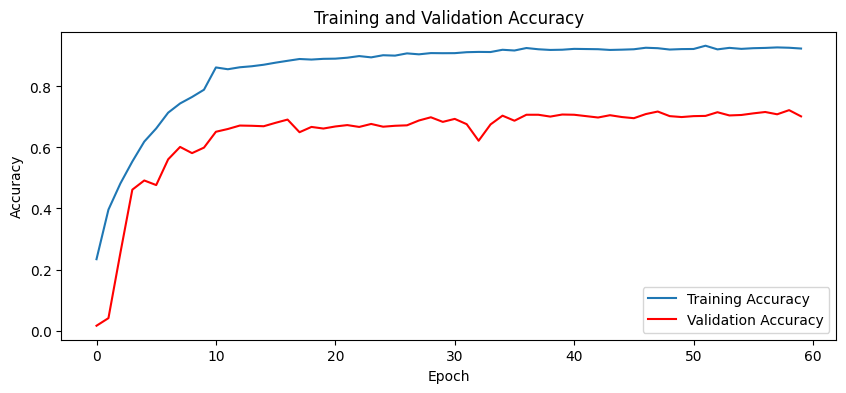

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(training_results['accuracy'], label='Training Accuracy')
plt.plot(training_results['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


The presented graph depicts the evolution of training and validation accuracies across epochs. A noticeable trend emerges as both accuracies appear to plateau around the 20th epoch, with marginal increases persisting thereafter. However, it is crucial to highlight that the training accuracy consistently outpaces the validation accuracy, suggesting a potential overfitting issue in the model. This overfitting is likely attributable to the constraints imposed by insufficient training data, particularly evident in cases where artists have just slightly more than 100 paintings. A potential resolution could involve adjusting the minimum threshold for the number of paintings per artist to 200 or 300. However, it's worth noting the deliberation behind maintaining a minimum of 100 paintings – a decision made to encompass as many artists from the dataset as possible.

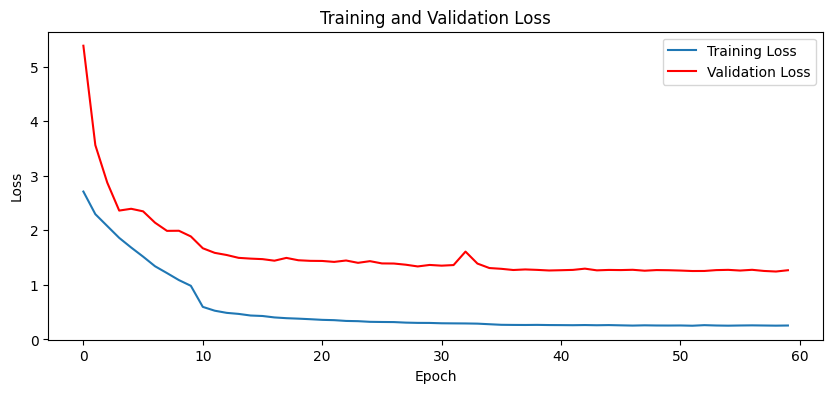

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(training_results['loss'], label='Training Loss')
plt.plot(training_results['val_loss'], label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

The depicted graph illustrates the training and validation loss values in relation to the number of epochs. In the context of ResNet50, loss serves as a metric gauging the model's efficacy in correctly categorizing images within the training data. Similar trends are discernible in this graph as those observed in the accuracy plot, notably the plateau phenomenon occurring post the 20th epoch and the discernible gap between the training and validation sets. These recurrent patterns are likely indicative of shared factors previously identified. The consistent plateau could be a result of the model reaching a saturation point in its learning capacity, while the discernible divergence between the training and validation sets hints at potential overfitting issues. As elucidated earlier, the root cause is traced back to the limitation imposed by insufficient training data, particularly prominent when artists have only slightly more than 100 paintings.






# Evaluating the Model's Performance

In [ ]:
score = model.evaluate(training_data_generator, verbose=1)
print("Training Accuracy =", score[1])

339/339 [==============================] - 88s 260ms/step - loss: 0.4517 - accuracy: 0.9340
Training Accuracy = 0.9339970350265503


In [ ]:
score = model.evaluate(validation_data_generator, verbose=1)
print("Validation Accuray =", score[1])

84/84 [==============================] - 21s 254ms/step - loss: 1.2845 - accuracy: 0.7050
Validation Accuray = 0.7050037384033203


The training accuracy and the validation accuracy confirm the previously suspected potential overfitting issue in my model. The substantial 20% disparity between the training and validation accuracies suggests that the model may be overly tailored to the training data, compromising its generalizability to unseen data. This observed overfitting is likely stemming from the constraint of limited data for a significant number of artists in the dataset. Despite implementing data augmentation as a strategy to mitigate this challenge, the improvement in performance is notable but falls short of entirely resolving the overfitting issue. I'm against increasing the minimum of 100 paintings however, as at that point I barely have any artists to have my model choose from. At this point, I'm curious to see in action my model doing what it was designed to do.

# The Moment of Truth: Can the Model Identify Artists from their Paintings?

The model succeeds at indentifying the correct artist in most circumstances. Here I'm printing 25 different images, and having the CNN predict who the responsible artist is. Running this code multiple times, it seems to get around 1 wrong for every 24 it gets correct (although that would put the validation accuracy at around 96%, so maybe I'm just getting lucky). While this is nowhere near perfect, it is definitely notable, especially after going into this project with no idea what a CNN is or how image classification is done using machine learning.

1/1 [==============================] - 0s 26ms/step


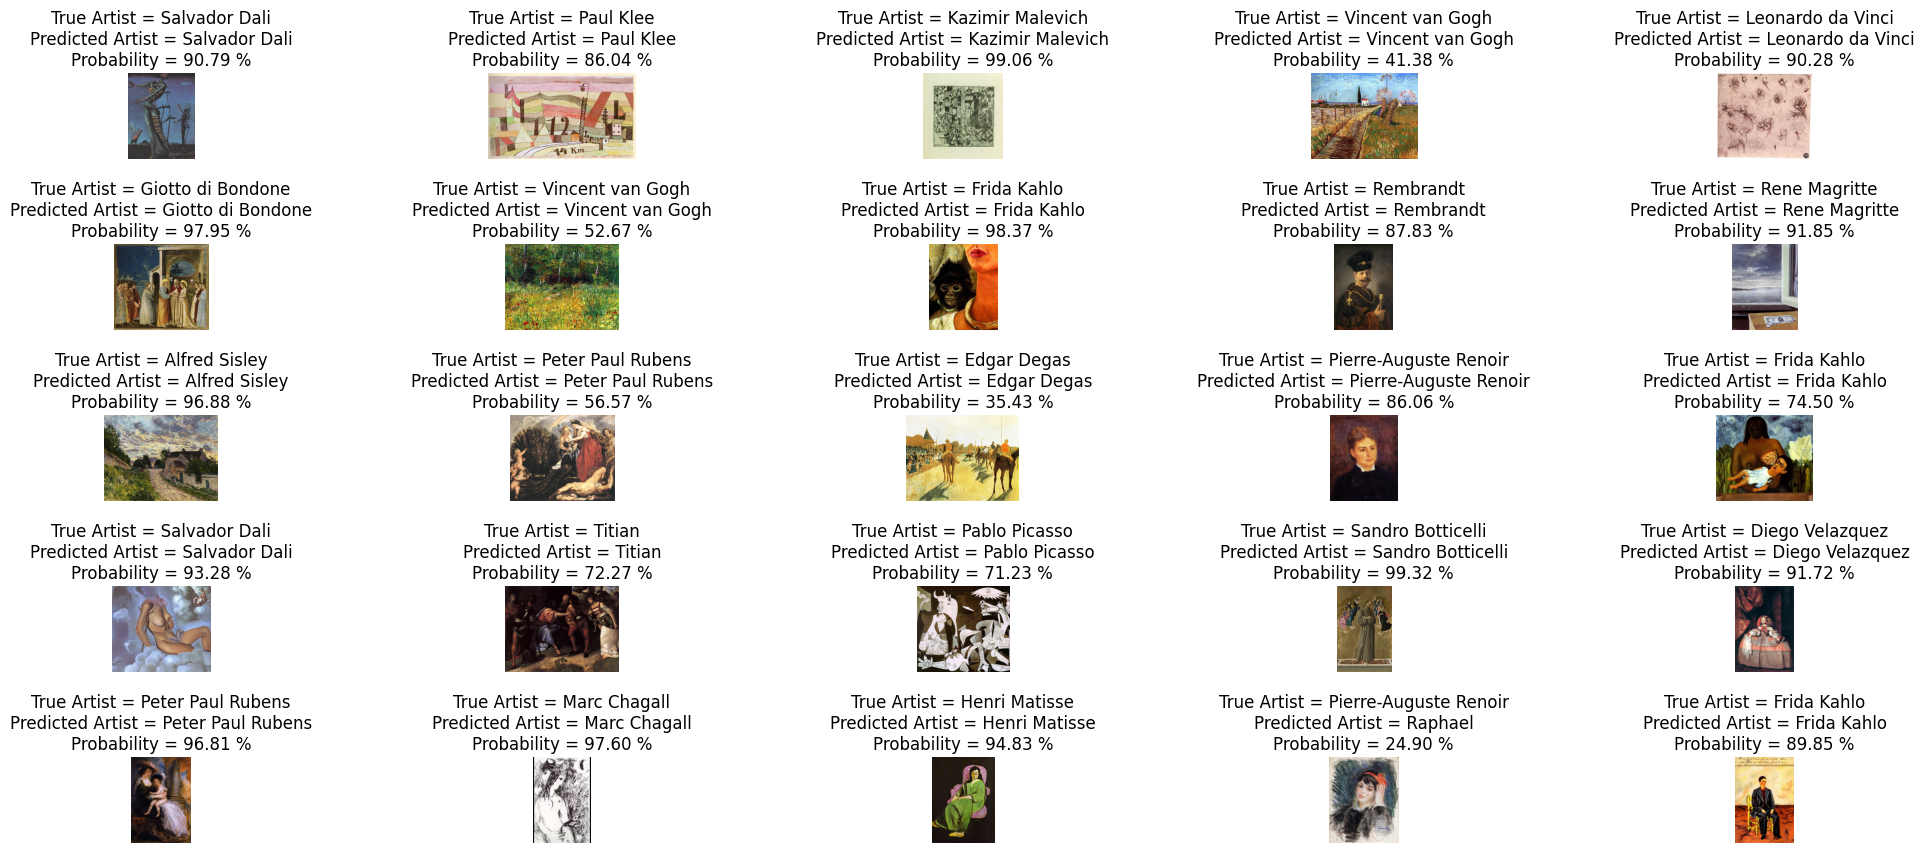

In [ ]:
num_rows = 5
num_columns = 5
fig, axes = plt.subplots(num_rows, num_columns, figsize=(25, 10))
plt.subplots_adjust(hspace=1)
for row in range(num_rows):
    for col in range(num_columns):
        chosen_artist = random.choice(df_names)
        chosen_image = random.choice(os.listdir(os.path.join(images_directory, chosen_artist)))
        chosen_file = os.path.join(images_directory, chosen_artist, chosen_image)
        test_image = image.load_img(chosen_file, target_size=(image_res[0], image_res[1]))
        test_image = image.img_to_array(test_image)
        test_image /= 255.
        test_image = np.expand_dims(test_image, axis=0)
        predicted_artist = model.predict(test_image)
        pred_prob = np.amax(predicted_artist)
        index = np.argmax(predicted_artist)
        dictionary = training_data_generator.class_indices
        dictionary = dict((v, k) for k, v in dictionary.items())
        title = "True Artist = {}\nPredicted Artist = {}\nProbability = {:.2f} %" \
        .format(chosen_artist.replace('_', ' '), dictionary[index].replace('_', ' '),pred_prob * 100)
        axes[row, col].imshow(plt.imread(chosen_file))
        axes[row, col].set_title(title)
        axes[row, col].axis('off')
plt.show()

# Conclusions


Embarking on this project, I underestimated the considerable demands—both in terms of resources and time—that this project would impose. A significant portion of my efforts was dedicated to navigating the challenges of efficiently processing the dataset and training the model. My initial miscalculation of the required volume of data necessary to train a CNN, both overall and per class, became evident as I strived for a higher validation accuracy. To address this in the future, an augmentation of the dataset by either increasing the number of images per class or reducing the number of classes (resulting in classes with more images) emerged as a crucial remedy. I have recognized the significance of surpassing the 100 painting minimum threshold I previously used, however doing so on this dataset would leave me with a very few number of artists remaining (11). Additionally, enhancing computing power would prove invaluable, enabling the concurrent execution of multiple models and facilitating the comparison of hyperparameters. If I ever were to redo this project in the future, I would take all of this into account. Despite the challenges faced and numerous areas for improvement, I take pride in achieving the primary objective of learning the utilization of a Convolutional Neural Network for discerning distinctive characteristics within images. My model demonstrated commendable success in predicting artists with a noteworthy accuracy rate. Furthermore, I have gained proficiency in employing CNNs and ResNet50, solidifying my understanding of these intricate technologies. This journey, though challenging, has been instrumental in expanding my expertise and skills in the realm of Machine Learning.